# **Data** and  **Libraries**

In [1]:
import pandas as pd

In [3]:
from keras.layers import Embedding
from keras.layers import LSTM
from keras.layers import Conv1D, MaxPooling1D
import numpy as np
from sklearn import metrics
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Concatenate
import keras
from keras.utils.vis_utils import plot_model
import pandas as pd

# **BERT**

In [14]:
import torch as th
from transformers import AutoModel, AutoTokenizer
import torch.nn.functional as F
from utils import *
import dgl
import torch.utils.data as Data
from ignite.engine import Events, create_supervised_evaluator, create_supervised_trainer, Engine
from ignite.metrics import Accuracy, Loss
from sklearn.metrics import accuracy_score
import numpy as np
import os
import shutil
import argparse
import sys
import logging
from datetime import datetime
from torch.optim import lr_scheduler
from model import BertGCN, BertGAT

OSError: libcudart.so.10.1: cannot open shared object file: No such file or directory

In [10]:
parser = argparse.ArgumentParser()
parser.add_argument('--max_length', type=int, default=128, help='the input length for bert')
parser.add_argument('--batch_size', type=int, default=16)
parser.add_argument('-m', '--m', type=float, default=0.7, help='the factor balancing BERT and GCN prediction')
parser.add_argument('--nb_epochs', type=int, default=50)
parser.add_argument('--bert_init', type=str, default='roberta-base',
                    choices=['roberta-base', 'roberta-large', 'bert-base-uncased', 'bert-large-uncased'])
parser.add_argument('--pretrained_bert_ckpt', default=None)
parser.add_argument('--dataset', default='programmableweb', choices=['20ng', 'R8', 'R52', 'ohsumed', 'mr','programmableweb'])
parser.add_argument('--checkpoint_dir', default=None, help='checkpoint directory, [bert_init]_[gcn_model]_[dataset] if not specified')
parser.add_argument('--gcn_model', type=str, default='gcn', choices=['gcn', 'gat'])
parser.add_argument('--gcn_layers', type=int, default=2)
parser.add_argument('--n_hidden', type=int, default=200, help='the dimension of gcn hidden layer, the dimension for gat is n_hidden * heads')
parser.add_argument('--heads', type=int, default=8, help='the number of attentionn heads for gat')
parser.add_argument('--dropout', type=float, default=0.5)
parser.add_argument('--gcn_lr', type=float, default=1e-3)
parser.add_argument('--bert_lr', type=float, default=1e-5)
parser.add_argument('-f')



NameError: name 'argparse' is not defined

In [13]:

args = parser.parse_args()
max_length = args.max_length
batch_size = args.batch_size
m = args.m
nb_epochs = args.nb_epochs
bert_init = args.bert_init
pretrained_bert_ckpt = args.pretrained_bert_ckpt
dataset = args.dataset
checkpoint_dir = args.checkpoint_dir
gcn_model = args.gcn_model
gcn_layers = args.gcn_layers
n_hidden = args.n_hidden
heads = args.heads
dropout = args.dropout
gcn_lr = args.gcn_lr
bert_lr = args.bert_lr



In [14]:
if checkpoint_dir is None:
    ckpt_dir = './gdrive/MyDrive/PFE/checkpoint/{}_{}'.format(bert_init, dataset)
else:
    ckpt_dir = checkpoint_dir

os.makedirs(ckpt_dir, exist_ok=True)
#shutil.copy(os.path.abspath('/content/gdrive/MyDrive/Colab Notebooks/test pfe.ipynb'), ckpt_dir)
sh = logging.StreamHandler(sys.stdout)
sh.setFormatter(logging.Formatter('%(message)s'))
sh.setLevel(logging.INFO)
fh = logging.FileHandler(filename=os.path.join(ckpt_dir, 'training.log'), mode='w')
fh.setFormatter(logging.Formatter('%(message)s'))
fh.setLevel(logging.INFO)
logger = logging.getLogger('training logger')
logger.addHandler(sh)
logger.addHandler(fh)
logger.setLevel(logging.INFO)

cpu = th.device('cpu')
gpu = th.device('cuda:0')
th.cuda.set_device(0)
gpu1 = 0
device = th.device(gpu1 if th.cuda.is_available() else "cpu")
if th.cuda.is_available():
    th.cuda.set_device(gpu1)

logger.info('arguments:')
logger.info(str(args))
logger.info('checkpoints will be saved in {}'.format(ckpt_dir))




arguments:
Namespace(batch_size=16, bert_init='roberta-base', bert_lr=1e-05, checkpoint_dir=None, dataset='programmableweb', dropout=0.5, f='/root/.local/share/jupyter/runtime/kernel-48c69ad5-47b4-46b8-aed5-78bd44f4175f.json', gcn_layers=2, gcn_lr=0.001, gcn_model='gcn', heads=8, m=0.7, max_length=128, n_hidden=200, nb_epochs=50, pretrained_bert_ckpt=None)
checkpoints will be saved in ./gdrive/MyDrive/PFE/checkpoint/roberta-base_programmableweb


In [15]:
 dataset

'programmableweb'

In [16]:
# Data Preprocess
adj, features, y_train, y_val, y_test, train_mask, val_mask, test_mask, train_size, test_size = load_corpus(dataset)
'''
y_train, y_val, y_test: n*c matrices 
train_mask, val_mask, test_mask: n-d bool array
train_size, test_size: unused
'''


(6471, 300) (6471, 20) (1269, 300) (1269, 20) (31863, 300) (31863, 20)
33132


'\ny_train, y_val, y_test: n*c matrices \ntrain_mask, val_mask, test_mask: n-d bool array\ntrain_size, test_size: unused\n'

In [17]:
# compute number of real train/val/test/word nodes and number of classes
nb_node = features.shape[0]
nb_train, nb_val, nb_test = train_mask.sum(), val_mask.sum(), test_mask.sum()
nb_word = nb_node - nb_train - nb_val - nb_test
nb_class = y_train.shape[1]

# instantiate model according to class number
if gcn_model == 'gcn':
    model = BertGCN(nb_class=nb_class, pretrained_model=bert_init, m=m, gcn_layers=gcn_layers,
                    n_hidden=n_hidden, dropout=dropout)
else:
    model = BertGAT(nb_class=nb_class, pretrained_model=bert_init, m=m, gcn_layers=gcn_layers,
                    heads=heads, n_hidden=n_hidden, dropout=dropout)


if pretrained_bert_ckpt is not None:
    ckpt = th.load(pretrained_bert_ckpt, map_location=gpu)
    model.bert_model.load_state_dict(ckpt['bert_model'])
    model.classifier.load_state_dict(ckpt['classifier'])




Downloading:   0%|          | 0.00/481 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/878k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/446k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.29M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/478M [00:00<?, ?B/s]

Some weights of the model checkpoint at roberta-base were not used when initializing RobertaModel: ['lm_head.layer_norm.weight', 'lm_head.decoder.weight', 'lm_head.dense.weight', 'lm_head.bias', 'lm_head.dense.bias', 'lm_head.layer_norm.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [18]:
from csv import reader

In [19]:
text=[]
corpse_file = '/content/gdrive/MyDrive/PFE/data/corpus/' + dataset +'_shuffle.csv'
with open(corpse_file, 'r') as read_obj:
    csv_reader = reader(read_obj)
    for row in csv_reader:
      text.extend(row)


In [20]:
np.shape(text)

(8459,)

In [21]:
# load documents and compute input encodings
'''
corpse_file = '/content/gdrive/MyDrive/PFE/data/corpus/' + dataset +'_shuffle.txt'
with open(corpse_file, 'r') as f:
    text = f.read()
    text = text.replace('\\', '')
    
    text = text.split('\n')
'''
def encode_input(text, tokenizer):
    input = tokenizer(text, max_length=max_length, truncation=True, padding='max_length', return_tensors='pt')
#     print(input.keys())
    return input.input_ids, input.attention_mask


input_ids, attention_mask = encode_input(text, model.tokenizer)
input_ids = th.cat([input_ids[:-nb_test], th.zeros((nb_word, max_length), dtype=th.long), input_ids[-nb_test:]])
attention_mask = th.cat([attention_mask[:-nb_test], th.zeros((nb_word, max_length), dtype=th.long), attention_mask[-nb_test:]])

# transform one-hot label to class ID for pytorch computation
y = y_train + y_test + y_val
y_train = y_train.argmax(axis=1)
y = y.argmax(axis=1)




In [22]:
np.shape(text)

(8459,)

In [23]:
print(attention_mask.shape)
print(input_ids.shape)
print(features.shape,adj.shape, features.shape, y_train.shape, y_val.shape, y_test.shape, train_mask.shape, val_mask.shape, test_mask.shape, train_size, test_size)
y

torch.Size([33132, 128])
torch.Size([33132, 128])
(33132, 300) (33132, 33132) (33132, 300) (33132,) (33132, 20) (33132, 20) (33132,) (33132,) (33132,) 7190 1269


array([10, 12,  4, ...,  4,  1,  3])

In [24]:
# document mask used for update feature
doc_mask  = train_mask + val_mask + test_mask

# build DGL Graph
adj_norm = normalize_adj(adj + sp.eye(adj.shape[0]))
g = dgl.from_scipy(adj_norm.astype('float32'), eweight_name='edge_weight')
g.ndata['input_ids'], g.ndata['attention_mask'] = input_ids, attention_mask
g.ndata['label'], g.ndata['train'], g.ndata['val'], g.ndata['test'] = \
    th.LongTensor(y), th.FloatTensor(train_mask), th.FloatTensor(val_mask), th.FloatTensor(test_mask)
g.ndata['label_train'] = th.LongTensor(y_train)
g.ndata['cls_feats'] = th.zeros((nb_node, model.feat_dim))

logger.info('graph information:')
logger.info(str(g))

# create index loader
train_idx = Data.TensorDataset(th.arange(0, nb_train, dtype=th.long))
val_idx = Data.TensorDataset(th.arange(nb_train, nb_train + nb_val, dtype=th.long))
test_idx = Data.TensorDataset(th.arange(nb_node-nb_test, nb_node, dtype=th.long))
doc_idx = Data.ConcatDataset([train_idx, val_idx, test_idx])

idx_loader_train = Data.DataLoader(train_idx, batch_size=batch_size, shuffle=True)
idx_loader_val = Data.DataLoader(val_idx, batch_size=batch_size)
idx_loader_test = Data.DataLoader(test_idx, batch_size=batch_size)
idx_loader = Data.DataLoader(doc_idx, batch_size=batch_size, shuffle=True)

# Training
def update_feature():
    global model, g, doc_mask
    # no gradient needed, uses a large batchsize to speed up the process
    dataloader = Data.DataLoader(
        Data.TensorDataset(g.ndata['input_ids'][doc_mask], g.ndata['attention_mask'][doc_mask]),
        batch_size=16
    )
    with th.no_grad():
        model = model.to(gpu)
        model.eval()
        cls_list = []
        for i, batch in enumerate(dataloader):
            input_ids, attention_mask = [x.to(gpu) for x in batch]
            output = model.bert_model(input_ids=input_ids, attention_mask=attention_mask)[0][:, 0]
            cls_list.append(output.cpu())
        cls_feat = th.cat(cls_list, axis=0)
    g = g.to(cpu)
    g.ndata['cls_feats'][doc_mask] = cls_feat
    return g


optimizer = th.optim.Adam([
        {'params': model.bert_model.parameters(), 'lr': bert_lr},
        {'params': model.classifier.parameters(), 'lr': bert_lr},
        {'params': model.gcn.parameters(), 'lr': gcn_lr},
    ], lr=1e-3
)
scheduler = lr_scheduler.MultiStepLR(optimizer, milestones=[30], gamma=0.1)




graph information:
Graph(num_nodes=33132, num_edges=3942792,
      ndata_schemes={'input_ids': Scheme(shape=(128,), dtype=torch.int64), 'attention_mask': Scheme(shape=(128,), dtype=torch.int64), 'label': Scheme(shape=(), dtype=torch.int64), 'train': Scheme(shape=(), dtype=torch.float32), 'val': Scheme(shape=(), dtype=torch.float32), 'test': Scheme(shape=(), dtype=torch.float32), 'label_train': Scheme(shape=(), dtype=torch.int64), 'cls_feats': Scheme(shape=(768,), dtype=torch.float32)}
      edata_schemes={'edge_weight': Scheme(shape=(), dtype=torch.float32)})


In [25]:
def train_step(engine, batch):
    global model, g, optimizer
    model.train()
    model = model.to(gpu)
    g = g.to(gpu)
    optimizer.zero_grad()
    (idx, ) = [x.to(gpu) for x in batch]
    optimizer.zero_grad()
    train_mask = g.ndata['train'][idx].type(th.BoolTensor)
    y_pred = model(g, idx)[train_mask]
    y_true = g.ndata['label_train'][idx][train_mask]
    loss = F.nll_loss(y_pred, y_true)
    loss.backward()
    optimizer.step()
    g.ndata['cls_feats'].detach_()
    train_loss = loss.item()
    with th.no_grad():
        if train_mask.sum() > 0:
            y_true = y_true.detach().cpu()
            y_pred = y_pred.argmax(axis=1).detach().cpu()
            train_acc = accuracy_score(y_true, y_pred)
        else:
            train_acc = 1
    return train_loss, train_acc


trainer = Engine(train_step)


@trainer.on(Events.EPOCH_COMPLETED)
def reset_graph(trainer):
    scheduler.step()
    update_feature()
    th.cuda.empty_cache()


def test_step(engine, batch):
    global model, g
    with th.no_grad():
        model.eval()
        model = model.to(gpu)
        g = g.to(gpu)
        (idx, ) = [x.to(gpu) for x in batch]
        y_pred = model(g, idx)
        y_true = g.ndata['label'][idx]
        return y_pred, y_true


evaluator = Engine(test_step)
metrics={
    'acc': Accuracy(),
    'nll': Loss(th.nn.NLLLoss())
}
for n, f in metrics.items():
    f.attach(evaluator, n)


@trainer.on(Events.EPOCH_COMPLETED)
def log_training_results(trainer):
    evaluator.run(idx_loader_train)
    metrics = evaluator.state.metrics
    train_acc, train_nll = metrics["acc"], metrics["nll"]
    evaluator.run(idx_loader_val)
    metrics = evaluator.state.metrics
    val_acc, val_nll = metrics["acc"], metrics["nll"]
    evaluator.run(idx_loader_test)
    metrics = evaluator.state.metrics
    test_acc, test_nll = metrics["acc"], metrics["nll"]
    logger.info(
        "Epoch: {}  Train acc: {:.4f} loss: {:.4f}  Val acc: {:.4f} loss: {:.4f}  Test acc: {:.4f} loss: {:.4f}"
        .format(trainer.state.epoch, train_acc, train_nll, val_acc, val_nll, test_acc, test_nll)
    )
    if val_acc > log_training_results.best_val_acc:
        logger.info("New checkpoint")
        th.save(
            {
                'bert_model': model.bert_model.state_dict(),
                'classifier': model.classifier.state_dict(),
                'gcn': model.gcn.state_dict(),
                'optimizer': optimizer.state_dict(),
                'epoch': trainer.state.epoch,
            },
            os.path.join(
                ckpt_dir, 'checkpoint.pth'
            )
        )
        log_training_results.best_val_acc = val_acc




In [26]:
log_training_results.best_val_acc = 0
g = update_feature()

In [ ]:
trainer.run(idx_loader, max_epochs=nb_epochs)

Epoch: 1  Train acc: 0.1072 loss: 2.9290  Val acc: 0.1099 loss: 2.9222  Test acc: 0.1095 loss: 2.9301
New checkpoint
Epoch: 2  Train acc: 0.1309 loss: 2.8952  Val acc: 0.1335 loss: 2.8741  Test acc: 0.1237 loss: 2.8973
New checkpoint
Epoch: 3  Train acc: 0.0957 loss: 2.9157  Val acc: 0.0932 loss: 2.8783  Test acc: 0.1048 loss: 2.9148
Epoch: 4  Train acc: 0.1269 loss: 2.8742  Val acc: 0.1280 loss: 2.8544  Test acc: 0.1253 loss: 2.8732
Epoch: 5  Train acc: 0.0859 loss: 2.9409  Val acc: 0.0876 loss: 2.9699  Test acc: 0.0764 loss: 3.0169
Epoch: 6  Train acc: 0.1269 loss: 2.9088  Val acc: 0.1113 loss: 3.0174  Test acc: 0.0883 loss: 3.0575
Epoch: 7  Train acc: 0.1284 loss: 2.8409  Val acc: 0.0584 loss: 3.2546  Test acc: 0.0528 loss: 3.3084
Epoch: 8  Train acc: 0.1980 loss: 2.5298  Val acc: 0.0807 loss: 3.3926  Test acc: 0.0827 loss: 3.3791
Epoch: 9  Train acc: 0.3023 loss: 2.2731  Val acc: 0.1099 loss: 3.6067  Test acc: 0.1048 loss: 3.5920
Epoch: 10  Train acc: 0.3349 loss: 2.1566  Val acc: 

In [2]:
f  =open('reslts.txt','r')

In [3]:
zlist = f.read()

In [4]:
zlist

'Epoch: 1  Train acc: 0.1072 loss: 2.9290  Val acc: 0.1099 loss: 2.9222  Test acc: 0.1095 loss: 2.9301\nEpoch: 2  Train acc: 0.1309 loss: 2.8952  Val acc: 0.1335 loss: 2.8741  Test acc: 0.1237 loss: 2.8973\nEpoch: 3  Train acc: 0.0957 loss: 2.9157  Val acc: 0.0932 loss: 2.8783  Test acc: 0.1048 loss: 2.9148\nEpoch: 4  Train acc: 0.1269 loss: 2.8742  Val acc: 0.1280 loss: 2.8544  Test acc: 0.1253 loss: 2.8732\nEpoch: 5  Train acc: 0.0859 loss: 2.9409  Val acc: 0.0876 loss: 2.9699  Test acc: 0.0764 loss: 3.0169\nEpoch: 6  Train acc: 0.1269 loss: 2.9088  Val acc: 0.1113 loss: 3.0174  Test acc: 0.0883 loss: 3.0575\nEpoch: 7  Train acc: 0.1284 loss: 2.8409  Val acc: 0.0584 loss: 3.2546  Test acc: 0.0528 loss: 3.3084\nEpoch: 8  Train acc: 0.1980 loss: 2.5298  Val acc: 0.0807 loss: 3.3926  Test acc: 0.0827 loss: 3.3791\nEpoch: 9  Train acc: 0.3023 loss: 2.2731  Val acc: 0.1099 loss: 3.6067  Test acc: 0.1048 loss: 3.5920\nEpoch: 10  Train acc: 0.3349 loss: 2.1566  Val acc: 0.1391 loss: 3.9661 

In [5]:
zlist  =zlist.split('\n')

In [39]:
accc = []
losss = []
val_accc = []
val_losss = []
ts_accc = []
ts_losss=[]
y_data =[]
for i in range(33):
  y_data.append(i)


In [40]:
for l in zlist:
  kk = l.split()
  accc.append(kk[4])
  losss.append(kk[6])
  val_accc.append(kk[9])
  val_losss.append(kk[11])
  ts_accc.append(kk[14])
  ts_losss.append(kk[16])


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: MatplotlibDeprecationWarning: ScaleBase got an unexpected keyword argument 'linthreshy'. In the future this will raise TypeError
  This is separate from the ipykernel package so we can avoid doing imports until


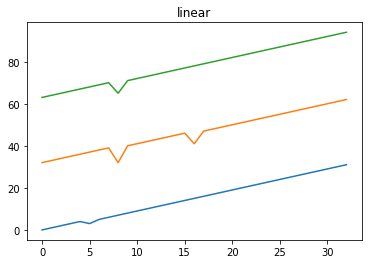

In [53]:
from matplotlib import pyplot as plt
plt.plot(y_data,accc)
plt.yscale('linear', linthreshy=0.01)
plt.title('linear')
plt.plot(y_data,val_accc)
plt.plot(y_data,ts_accc)
plt.show()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: MatplotlibDeprecationWarning: ScaleBase got an unexpected keyword argument 'linthreshy'. In the future this will raise TypeError
  This is separate from the ipykernel package so we can avoid doing imports until


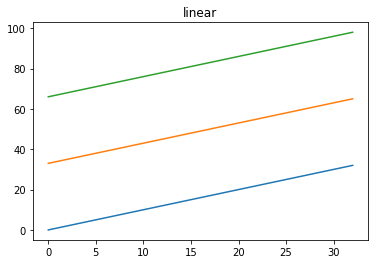

In [54]:
from matplotlib import pyplot as plt
plt.plot(y_data,losss)
plt.yscale('linear', linthreshy=0.01)
plt.title('linear')
plt.plot(y_data,val_losss)
plt.plot(y_data,ts_losss)
plt.show()